First, we will import the libraries we will use. We will focus our data mainly from numpy converted from the Dataframe we obtained form yahoo finance

In [27]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas_datareader.data as web
import pandas_datareader as pdr
from datetime import datetime
from pandas import Series,DataFrame

We will create a list, if in some future we decide to implement our model in more assets

In [28]:
my_list = ['USDMXN=X']

We will state the start and end of our data time in days.

In [29]:
end = datetime.now()

start = datetime(end.year-14,end.month,end.day) 

Using globals method, we will obtain the Dataframe from yahoo finance to obtain our assets price data.

In [30]:
for currency in my_list:
    globals()[currency.replace('=X', "")] = web.DataReader(currency,'yahoo',start,end)

In [31]:
USDMXN.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-01,21.435320,21.117599,21.404699,21.411800,0.0,21.411800
2021-12-02,21.477980,21.239981,21.462900,21.471569,0.0,21.471569
2021-12-03,21.486099,21.153000,21.296101,21.308540,0.0,21.308540
2021-12-06,21.294760,21.159901,21.223499,21.221001,0.0,21.221001
2021-12-07,21.304010,21.013000,21.223200,21.058201,0.0,21.058201


In [32]:
USDMXN.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3649.000000,3649.000000,3649.000000,3649.000000,3649.0,3649.000000
mean,15.951963,15.769423,15.855533,15.857140,0.0,15.857140
std,3.553348,3.501710,3.526766,3.525552,0.0,3.525552
min,9.933700,9.834000,9.866500,9.866500,0.0,9.866500
25%,12.977060,12.835900,12.903000,12.906790,0.0,12.906790
50%,14.734640,14.576000,14.659000,14.661700,0.0,14.661700
75%,19.175591,18.998550,19.083000,19.084999,0.0,19.084999
max,25.765341,24.728029,25.315100,25.336201,0.0,25.336201


In [33]:
USDMXN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3649 entries, 2007-12-07 to 2021-12-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3649 non-null   float64
 1   Low        3649 non-null   float64
 2   Open       3649 non-null   float64
 3   Close      3649 non-null   float64
 4   Volume     3649 non-null   float64
 5   Adj Close  3649 non-null   float64
dtypes: float64(6)
memory usage: 199.6 KB


<AxesSubplot:xlabel='Date'>

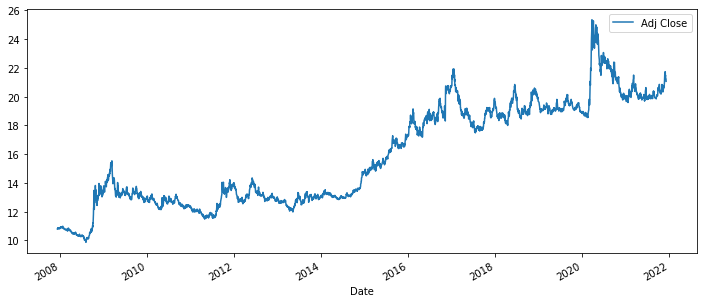

In [34]:
USDMXN['Adj Close'].plot(legend=True,figsize=(12,5))

We will create a numpy array of our Adjusted daily prices

In [35]:
df = USDMXN
p = df['Adj Close'].to_numpy()
l = []

In [36]:
tf.compat.v1.reset_default_graph()

We will state: ts= time steps, m= number of price ticks, c= comission, 2 pips. and batch size which will be 1

In [37]:
n = len(p)
ts = 10
m = 50
c = 0.0002
batch_size = 3

We will get the price differences with numpy changig the shape and we will state our decisions, which are buy=1, 0=hold, and -1=sell.

In [38]:
z = np.array([p[i+1] - p[i] for i in range(n-1)])
z = z.reshape([n-1,1])
decisions = np.array([1,0,-1])

In [39]:
def next_batch(t):
    l1 = ind
    
    l2 = ind+m+ts
    
    return z[l1:l2]

In [40]:
def init_weights(shape):
    rn = tf.random.normal(shape)
    return tf.Variable(rn)

In [41]:
def inp_layer(x,W,b):
    return tf.matmul(tf.transpose(W),x) + b

In [42]:
def out_inp_layer(d,U):
    return tf.matmul(tf.transpose(U),d)

In [43]:
def output(x,y):
    return tf.tanh(x+y)

In [44]:
def forward_prop(ft,dt,W,b,U):
    i1 = inp_layer(ft,W,b)
    i2 = out_inp_layer(dt,U)
    o = output(i1,i2)
    return o

In [45]:
def unfolded(features,W,b,U,dt):
    delta = [dt]
    r = []
    for i in range(1,ts+1):
        f = tf.slice(features,[i-1,0],[m,1])
        l.append(f)
        delta.append(forward_prop(f,delta[i-1],W,b,U))
        Rt = delta[i-1]*z[i-1] - c*tf.abs(delta[i] - delta[i-1])
        r.append(Rt)
    UT = sum(r)
    return UT,r,delta

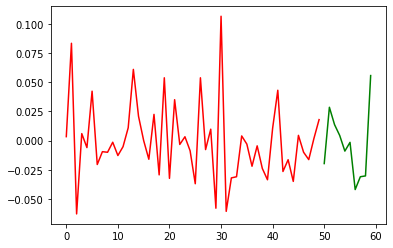

In [46]:
plt.plot([i for i in range(m)],z[0:m],'r')
plt.plot([i for i in range(m,m+ts)],z[m:m+ts],'g')

In [47]:
obj = []
learning_rate = 0.01

In [48]:
tf.compat.v1.disable_eager_execution()

In [49]:
W = init_weights([m,1])
U = init_weights([1,1])
b = init_weights([1,1])
dt = tf.Variable(tf.zeros([1,1]),dtype=tf.float32,trainable=False)
features = tf.compat.v1.placeholder(tf.float32,shape = [m+ts,1])
UT,r,delta = unfolded(features,W,b,U,dt)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(-UT)

In [50]:
aver = tf.compat.v1.train.Saver()
init = tf.compat.v1.global_variables_initializer()
steps = 1
epochs = 2000
with tf.compat.v1.Session() as sess:
    sess.run(init)
    for j in range(epochs):
        ind = 0
        for i in range(steps):
            x_curr = next_batch(ind)
            _,val,delt,w = sess.run([train,UT,delta,W],feed_dict = {features:x_curr.reshape([m+ts,1])})
            obj.append(val[0][0])
            ind = ind + m+ts
    print(val)
    saver = tf.compat.v1.train.Saver()
    saver.save(sess, "./currency")
    

[[0.21632499]]


In [51]:
len(z[0:ts])

10

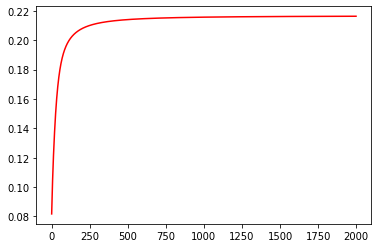

In [52]:
plt.plot(obj,'r')